### Visualization of the first 9999 jobs as they progress through the production lines

In [1]:
###Data pre-processing###

options(warn=-1) #surpress warnings

#imports for data wrangling
library(data.table)
library(dtplyr)
library(dplyr)




Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#get the data - nrows set to 10000 to keep runtime manageable.
#one expansion option would be to select a time frame to visualized
NumericData <- fread("../input/train_numeric.csv", select = c("Id", "Response"),nrows = 10000)
Date <- fread("../input/train_date.csv", nrows = 10000)



In [3]:
#for each job identify which stations are passed through and for those store the minimum time
for (station in paste0("S",0:51))
{
  cols = min(which((grepl(station,colnames(Date)))))
  if(!cols==Inf){
    Date[,paste0(station) := Date[,cols,with = FALSE]]
  }
}



In [4]:
#limit data to only when passed through station X
Stations = Date[,!grepl("L",colnames(Date)),with=F]

#melt data to go from wide to long format
Stations_long = melt(Stations,id.vars=c("Id"))

#join with numeric to have Response
Stations_long <- left_join(NumericData, by="Id", Stations_long)


#remove NA entries - these are plentiful as after melting each station-job combination has its own row
Stations_filtered<-filter(Stations_long,!is.na(value))


#sort entries by ascending time
Stations_filtered<-arrange(Stations_filtered, value)





In [5]:
## Help sought from: https://www.kaggle.com/gingerman/bosch-production-line-performance/shopfloor-visualization

#imports for plotting
require(GGally)
library(network)
library(sna)
library(ggplot2)

#plotting format
options(repr.plot.width=5, repr.plot.height=15)

#for each row obtain the subsequent station
edgelistsComplete<-mutate(group_by(Stations_filtered, Id), nextStation = lead(variable))


#for each id find the first node to be entered 
startingPoints<-select(ungroup(filter(group_by(edgelistsComplete,Id),!(variable %in% nextStation))),variable, Response)


#prior to each starting point insert an edge from a common origin
colnames(startingPoints) = c("nextStation","Response")
startingPoints$variable = "S"
paths<-select(edgelistsComplete,variable,nextStation,Response)


#for each id find the row where there is no next station (last station to be visited)
#fill this station with Response value
paths[is.na(nextStation)]$nextStation = paste("Result",paths[is.na(nextStation)]$Response)

#combine data
paths = rbind(startingPoints,paths)
paths = select(paths,-Response)
paths$nextStation = as.character(paths$nextStation)
paths$variable = as.character(paths$variable)

#rename columns for plotting
colnames(paths) <- c("Target","Source")

#flip columns in a costly way because ggnet is a little dumb and I am lazy
pathshelp = select(paths,Source)
pathshelp$Target = paths$Target
paths=pathshelp

#create network from edgelist
net = network(as.data.frame(na.omit(paths)),
              directed = TRUE)

#create a station-line mapping lookup
LineStations = NULL
for (station in unique(paths$Source)){
  if(station!="S")
  {
  x=paste0("_",station,"_")
  y=head(colnames(Date)[which(grepl(x,colnames(Date)))],1)
  y=strsplit(y,"_")[[1]][1]
  LineStations = rbind(LineStations,data.frame(Node=station,Line=y))
  }
}
LineStations = rbind(LineStations,data.frame(Node=c("Result 1","Result 0","S"),Line=c("Outcome","Outcome","START")))

#merge station-line mapping into graph for coloring purposes
x = data.frame(Node = network.vertex.names(net))
x = merge(x, LineStations, by = "Node", sort = FALSE)$Line
net %v% "line" = as.character(x)

#setup station coordinates 
nodeCoordinates=data.frame(label=c("S","S0","S1","S2","S3","S4","S5","S6",
                                  "S7","S8","S9","S10","S11","S12","S13",
                                  "S14","S15","S16","S17","S18","S19",
                                  "S20","S21","S22","S23","S24","S25",
                                  "S26","S27","S28","S29","S30","S31",
                                  "S32","S33","S34","S35","S36","S37",
                                  "S38","S39","S40","S41","S43",
                                  "S44","S45","S47","S48","S49",
                                  "S50","S51","Result 0","Result 1"),
                           y=c(0,
                               1,2,3,3,4,4,5,5,6,7,7,7,
                               1,2,3,3,4,4,5,5,6,7,7,7,
                               6,6,7,7,7,
                               8,9,10,10,10,11,11,12,13,14,
                               8,9,10,11,11,12,13,14,15,15,16,
                               17,17),
                           x=c(5,
                               9,9,10,8,10,8,10,8,7,10,9,8,
                               5,5,6,4,6,4,6,4,5,6,5,4,
                               2,0,2,1,0,
                               7,7,8,7,6,8,6,7,7,7,
                               3,3,3,4,2,3,3,3,4,2,3,
                               7,3))

nodeCoordinates$y = -3 * nodeCoordinates$y

#setup initial plot
network = ggnet2(net)

#grab node list from initial plot and attach coordinates
Coordinates = select(network$data,label)
Coordinates = left_join(Coordinates,nodeCoordinates,by = "label")
Coordinates = as.matrix(select(Coordinates,x,y))

#setup plot with manual layout
network = ggnet2(net,
                 alpha = 0.75, size = "indegree",
                 label = T, size.cut = 4,
                 color = "line",palette = "Set1",
                 mode = Coordinates,
                 edge.alpha = 0.5, edge.size = 1,
                 legend.position = "bottom")




Loading required package: GGally

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

Loading required package: statnet.common
sna: Tools for Social Network Analysis
Version 2.4 created on 2016-07-23.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.

Loading required package: scales


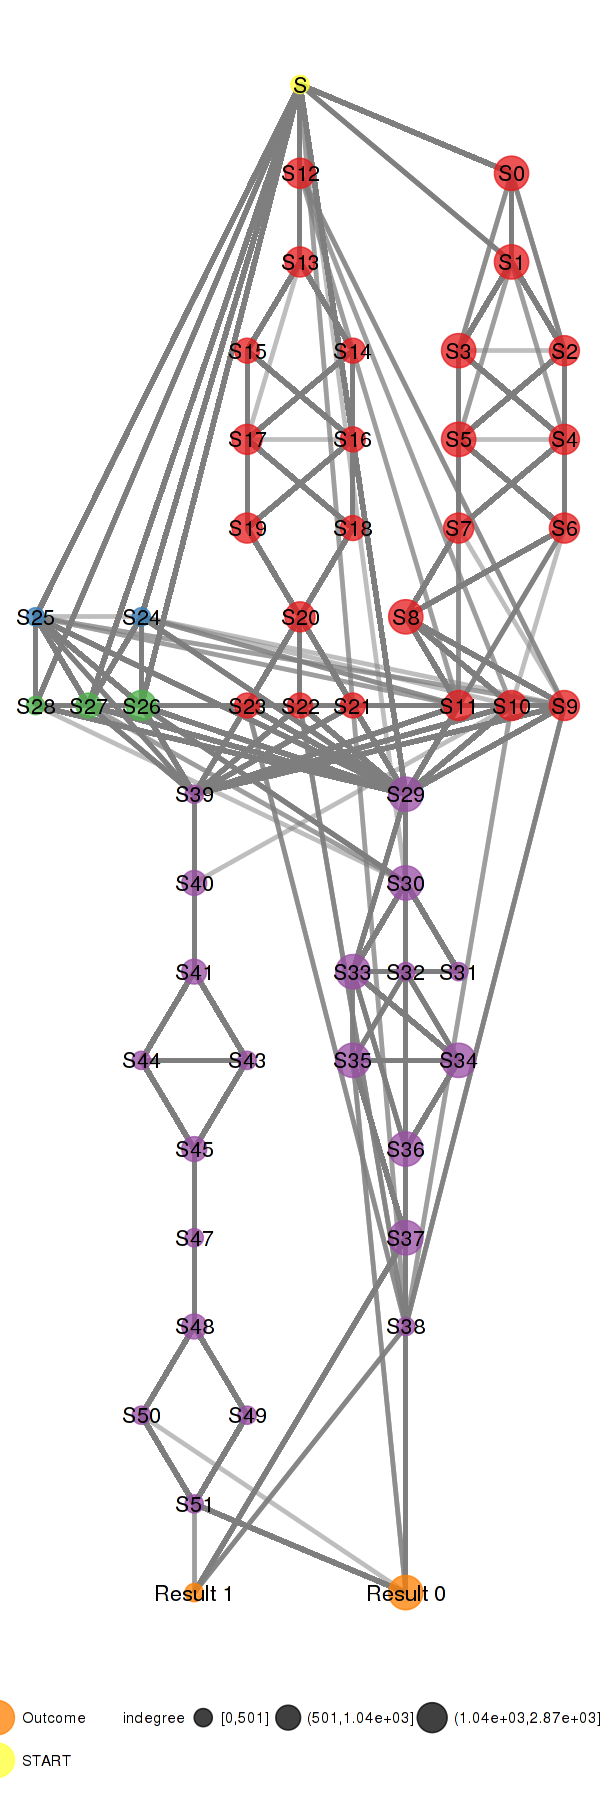

In [6]:
#output plot on graphics device
print(network)